# Baroclinicity
Show baroclinicity in the undercurrent

In [1]:
#%%IMPORTING
import xarray as xr
import os
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

import numpy as np
from scipy import stats
import pandas as pd
import datetime
import matplotlib.colors as colors
divnorm = colors.TwoSlopeNorm(vcenter=0)

from functions.loading_and_processing_data import loadMITgcmData,loadTimeSeriesData, detrend_and_average_MITgcmData
from functions.composite_maps import createCompositeMap, createVelocityCompositeMap, defineEvents, findEvents

import sys
sys.path.append('/data/hpcdata/users/grejan/mitgcm/') #Make sure we can also import Kaitlins code.
from mitgcm_python_master.diagnostics import density
from mitgcm_python_master.plot_utils.labels import slice_axes 


### Read and process the data

In [2]:
%%capture

#Read the data
lon=115
members='all'

#Read velocity
dataU=loadMITgcmData(filename='UVEL_W'+str(lon), members=members, kind='slices')

#Read temperature and salinity
dataS=loadMITgcmData(filename='SALT_W'+str(lon), members=members, kind='slices')
dataT=loadMITgcmData(filename='THETA_W'+str(lon), members=members, kind='slices')

#Read Mass Loss
melt=loadTimeSeriesData(filename='timeseries_final', members=members, kind='old')['dotson_to_cosgrove_massloss']

In [3]:
#Select relevant years
dataU=dataU.sel(time=slice('1920', '2013'))
dataS=dataS.sel(time=slice('1920', '2013'))
dataT=dataT.sel(time=slice('1920', '2013'))

#Detrend the data
meltrm=detrend_and_average_MITgcmData(melt.to_dataset(name='melt'), var='melt', window=60)
data_dt=detrend_and_average_MITgcmData(dataU, var='UVEL', window=1)

#Remove 0 values (that is: land!)
dataU=dataU.where(dataU!=0, drop=True)
dataS=dataS.where(dataS!=0, drop=True)
dataT=dataT.where(dataT!=0, drop=True)
data_dt=data_dt.where(data_dt!=0, drop=True)

#Select high and low melt times
Umean1=data_dt.where(meltrm>meltrm.quantile(0.9)).mean(dim=['time', 'ens'])
Umean2=data_dt.where(meltrm<meltrm.quantile(0.1)).mean(dim=['time', 'ens'])

In [4]:
%%capture

#Compute the isopycnals
#Convert everything to density.
ref_depth=0
eosType='MDJWF'
salt=dataS['SALT'].to_numpy()
temp=dataT['THETA'].to_numpy()
q=density (eosType, salt, temp, press=ref_depth)
q=xr.DataArray(q, dims=('ens', 'time', "Z", "YC"), coords={'ens': dataS['SALT'].ens, 'time': dataS['SALT'].time, "YC": dataS['SALT'].YC, "Z": dataS['SALT'].Z})

#Compute isopycnals
dqdz=q.differentiate('Z')
dqdy=q.differentiate('YC')/111e3
dzdy=-dqdy/dqdz

In [5]:
#Detrend isopycnals
dzdy_dt=detrend_and_average_MITgcmData(dzdy.to_dataset(name='slope'), var='slope', window=1)
dzdymean1=dzdy_dt.where(meltrm>meltrm.quantile(0.9)).mean(dim=['time', 'ens'])
dzdymean2=dzdy_dt.where(meltrm<meltrm.quantile(0.1)).mean(dim=['time', 'ens'])

In [6]:
#Compute time-mean
Umean=dataU.sel(time=slice('1920', '2013')).mean(dim=['ens', 'time'])
dzdymean=dzdy.sel(time=slice('1920', '2013')).mean(dim=['ens', 'time'])

/data/hpcdata/users/grejan/mitgcm/mitgcm_python_master/plot_utils/labels.py:149: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(z_labels)


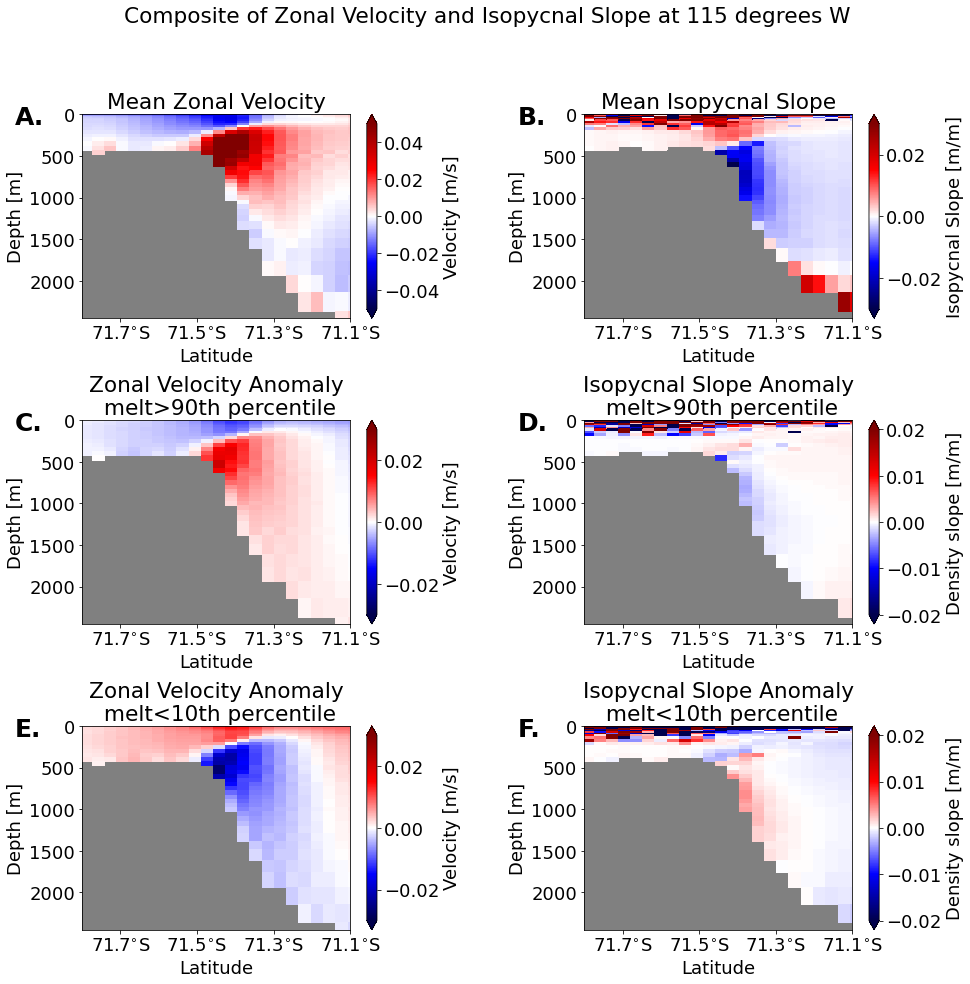

In [7]:
fig=plt.figure(figsize=(15,15))

plt.rcParams.update({'font.size': 18})

ax=plt.subplot(3,2,1)
ax.set_title('Mean Zonal Velocity')
img=ax.pcolor(Umean.YC, Umean.Z, Umean['UVEL'], cmap='seismic', vmin=-0.05, vmax=0.05)
plt.colorbar(img, label='Velocity [m/s]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2450, 0])
ax.set_xticks([-71.7, -71.5, -71.3, -71.1])
slice_axes(ax) 
ax.set_ylabel('Depth [m]', fontsize=18)
ax.set_xlabel('Latitude', fontsize=18)
ax.set_facecolor('grey')

ax=plt.subplot(3,2,2)
ax.set_title('Mean Isopycnal Slope')
img=ax.pcolor(dzdymean.YC, dzdymean.Z, dzdymean, cmap='seismic', vmin=-3e-2, vmax=3e-2)
plt.colorbar(img, label='Isopycnal Slope [m/m]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2450, 0])
ax.set_xticks([-71.7, -71.5, -71.3, -71.1])
slice_axes(ax) 
ax.set_ylabel('Depth [m]', fontsize=18)
ax.set_xlabel('Latitude', fontsize=18)
ax.set_facecolor('grey')

ax=plt.subplot(3,2,3)
ax.set_title('Zonal Velocity Anomaly\n melt>90th percentile')
img=ax.pcolor(Umean1.YC, Umean1.Z, Umean1, cmap='seismic', vmin=-0.03, vmax=0.03)
plt.colorbar(img, label='Velocity [m/s]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2450, 0])
ax.set_xticks([-71.7, -71.5, -71.3, -71.1])
slice_axes(ax) 
ax.set_ylabel('Depth [m]', fontsize=18)
ax.set_xlabel('Latitude', fontsize=18)
ax.set_facecolor('grey')


ax=plt.subplot(3,2,4)
ax.set_title('Isopycnal Slope Anomaly\n melt>90th percentile')
img=ax.pcolor(dzdymean1.YC, dzdymean1.Z, dzdymean1, cmap='seismic', vmin=-2e-2, vmax=2e-2)
plt.colorbar(img, label='Density slope [m/m]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2450, 0])
ax.set_xticks([-71.7, -71.5, -71.3, -71.1])
slice_axes(ax) 
ax.set_ylabel('Depth [m]', fontsize=18)
ax.set_xlabel('Latitude', fontsize=18)
ax.set_facecolor('grey')

ax=plt.subplot(3,2,5)
ax.set_title('Zonal Velocity Anomaly\n melt<10th percentile')
img=ax.pcolor(Umean2.YC, Umean2.Z, Umean2, cmap='seismic', vmin=-0.03, vmax=0.03)
plt.colorbar(img, label='Velocity [m/s]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2450, 0])
ax.set_xticks([-71.7, -71.5, -71.3, -71.1])
slice_axes(ax) 
ax.set_ylabel('Depth [m]', fontsize=18)
ax.set_xlabel('Latitude', fontsize=18)
ax.set_facecolor('grey')

ax=plt.subplot(3,2,6)
ax.set_title('Isopycnal Slope Anomaly\n melt<10th percentile')
img=ax.pcolor(dzdymean2.YC, dzdymean2.Z, dzdymean2, cmap='seismic', vmin=-2e-2, vmax=2e-2)
plt.colorbar(img, label='Density slope [m/m]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2450, 0])
ax.set_xticks([-71.7, -71.5, -71.3, -71.1])
slice_axes(ax) 
ax.set_ylabel('Depth [m]', fontsize=18)
ax.set_xlabel('Latitude', fontsize=18)
ax.set_facecolor('grey')

fig.suptitle('Composite of Zonal Velocity and Isopycnal Slope at 115 degrees W')
import string
for n, ax in enumerate(fig.axes[::2]):
    ax.text(-0.25, 0.95, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
            size=25, weight='bold')
fig.subplots_adjust(wspace=0.5, hspace=0.5)
fig.savefig('../03_output/slices/new_UVEL_ISOPYCN_W115.png')

### Surface Freshwater Budget

In [32]:
%%capture
#Load the Data
forcing=loadTimeSeriesData(filename='timeseries_forcing', members='all', kind='old')
forcing['time']=forcing.indexes['time'].to_datetimeindex()
melt=loadTimeSeriesData(filename='timeseries_final', members='all', kind='old')
melt['time']=melt.indexes['time'].to_datetimeindex()
salt=loadTimeSeriesData(filename='timeseries_salt_0to200', members='all', kind='timeseries')
salt['time']=salt.indexes['time'].to_datetimeindex()

In [33]:
#Convert everything to the same units and select years
factor= 10**9/(917*365*24*3600) #Gt/yr to m^3/s
shelf=melt['all_massloss'].sel(time=slice('1920', '2013'))*factor
seaice=(forcing['amundsen_shelf_seaice_freeze']+forcing['amundsen_shelf_seaice_melt']).sel(time=slice('1920', '2013'))
prec=forcing['amundsen_shelf_pmepr'].sel(time=slice('1920', '2013'))

#Detrend the data
shelf_dt=detrend_and_average_MITgcmData(shelf.to_dataset(name='shelf'), var='shelf', window=60)
seaice_dt=detrend_and_average_MITgcmData(seaice.to_dataset(name='seaice'), var='seaice', window=60)
prec_dt=detrend_and_average_MITgcmData(prec.to_dataset(name='prec'), var='prec', window=60)

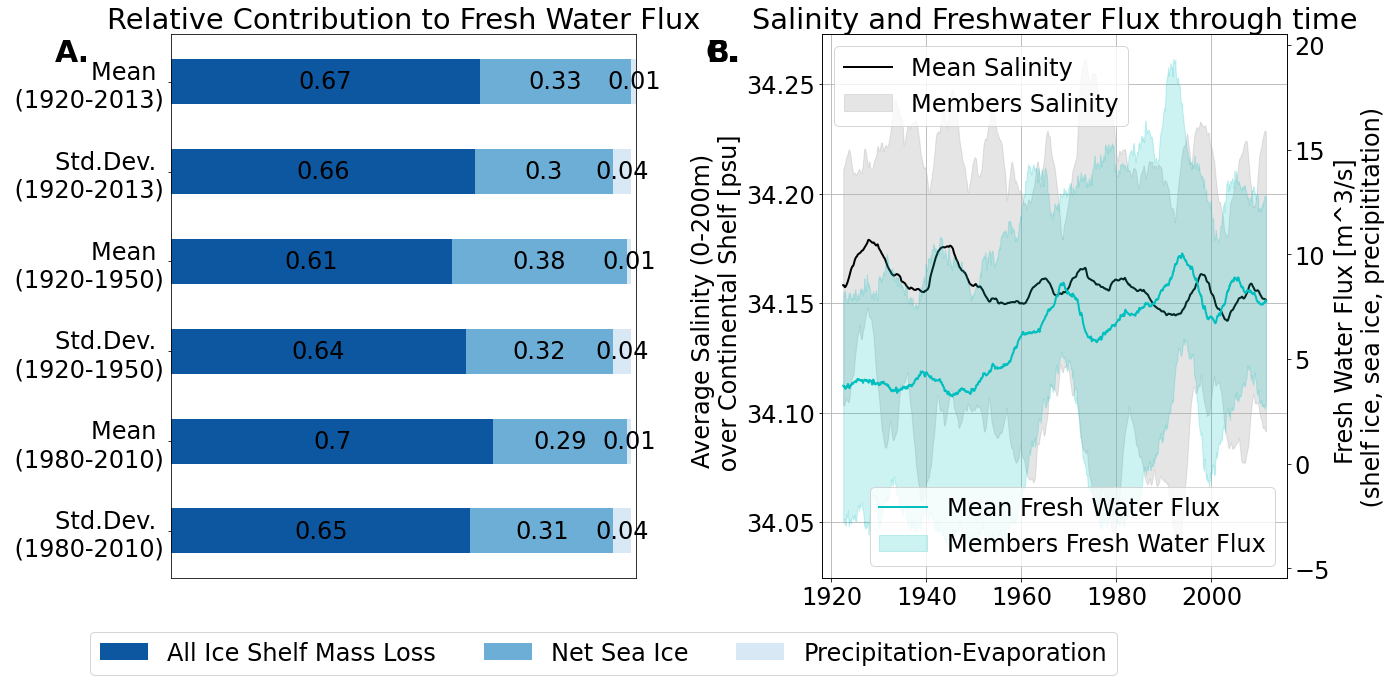

In [83]:
category_names = ['All Ice Shelf Mass Loss', 'Net Sea Ice',
                  'Precipitation-Evaporation']

#Compute the relative size of the mean freshwater fluxes
shelfmean=abs(shelf.mean(dim=['time', 'ens']))
seaicemean=abs(seaice.mean(dim=['time', 'ens']))
precmean=abs(prec.mean(dim=['time', 'ens']))
fullmean=shelfmean+seaicemean+precmean
shelfmean/=fullmean
seaicemean/=fullmean
precmean/=fullmean

#Compute the standard deviation of the freshwater fluxes
shelfstd=abs(shelf_dt.std(dim='time').mean(dim=['ens']))
seaicestd=abs(seaice_dt.std(dim='time').mean(dim=['ens']))
precstd=abs(prec_dt.std(dim='time').mean(dim=['ens']))
fullstd=shelfstd+seaicestd+precstd
shelfstd/=fullstd
seaicestd/=fullstd
precstd/=fullstd

#Compute freshwater fluxes until 1950
shelfmean_1950=abs(shelf.sel(time=slice('1920', '1950')).mean(dim=['time', 'ens']))
seaicemean_1950=abs(seaice.sel(time=slice('1920', '1950')).mean(dim=['time', 'ens']))
precmean_1950=abs(prec.sel(time=slice('1920', '1950')).mean(dim=['time', 'ens']))
fullmean_1950=shelfmean_1950+seaicemean_1950+precmean_1950
shelfmean_1950/=fullmean_1950
seaicemean_1950/=fullmean_1950
precmean_1950/=fullmean_1950


shelfstd_1950=abs(shelf_dt.sel(time=slice('1920', '1950')).std(dim='time').mean(dim=['ens']))
seaicestd_1950=abs(seaice_dt.sel(time=slice('1920', '1950')).std(dim='time').mean(dim=['ens']))
precstd_1950=abs(prec_dt.sel(time=slice('1920', '1950')).std(dim='time').mean(dim=['ens']))
fullstd_1950=shelfstd_1950+seaicestd_1950+precstd_1950
shelfstd_1950/=fullstd_1950
seaicestd_1950/=fullstd_1950
precstd_1950/=fullstd_1950

#Compute freshwater fluxes 1980-2010
shelfmean_2010=abs(shelf.sel(time=slice('1980', '2010')).mean(dim=['time', 'ens']))
seaicemean_2010=abs(seaice.sel(time=slice('1980', '2010')).mean(dim=['time', 'ens']))
precmean_2010=abs(prec.sel(time=slice('1980', '2010')).mean(dim=['time', 'ens']))
fullmean_2010=shelfmean_2010+seaicemean_2010+precmean_2010
shelfmean_2010/=fullmean_2010
seaicemean_2010/=fullmean_2010
precmean_2010/=fullmean_2010


shelfstd_2010=abs(shelf_dt.sel(time=slice('1980', '2010')).std(dim='time').mean(dim=['ens']))
seaicestd_2010=abs(seaice_dt.sel(time=slice('1980', '2010')).std(dim='time').mean(dim=['ens']))
precstd_2010=abs(prec_dt.sel(time=slice('1980', '2010')).std(dim='time').mean(dim=['ens']))
fullstd_2010=shelfstd_2010+seaicestd_2010+precstd_2010
shelfstd_2010/=fullstd_2010
seaicestd_2010/=fullstd_2010
precstd_2010/=fullstd_2010


#Plot the relative size of the fluxes.
results = {
    'Mean \n (1920-2013)': [np.round(shelfmean,2), np.round(seaicemean,2),  np.round(precmean,2)],
    'Std.Dev. \n (1920-2013)': 
    [np.round(shelfstd,2), np.round(seaicestd,2),  np.round(precstd,2)],
    
    'Mean \n (1920-1950)': [np.round(shelfmean_1950,2), np.round(seaicemean_1950,2),  np.round(precmean_1950,2)],
    'Std.Dev. \n (1920-1950)': 
    [np.round(shelfstd_1950,2), np.round(seaicestd_1950,2),  np.round(precstd_1950,2)],
    
    'Mean \n (1980-2010)': [np.round(shelfmean_2010,2), np.round(seaicemean_2010,2),  np.round(precmean_2010,2)],
    'Std.Dev. \n (1980-2010)': 
    [np.round(shelfstd_2010,2), np.round(seaicestd_2010,2),  np.round(precstd_2010,2)],
}

#Plot 
def survey(results, category_names, ax):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['Blues_r'](
        np.linspace(0.15, 0.85, data.shape[1]))

    #fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'black' #if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(-0.2, -0.2),
              loc='lower left')

    return ax

plt.rcParams.update({'font.size': 24})

fig=plt.figure(figsize=(20,10))
ax=plt.subplot(1,2,1)
ax=survey(results, category_names, ax)
ax.set_title('Relative Contribution to Fresh Water Flux')


cumul=shelf+seaice+prec
#cumul['time']=cumul.indexes['time'].to_datetimeindex()
#salt['time']=salt.indexes['time'].to_datetimeindex()


ax=plt.subplot(1,2,2)
mean=salt['amundsen_shelf_salt_btw_0_200m'].mean(dim='ens').sel(
        time=slice('1920', '2013')).rolling(time=60, center=True).mean()
maximum=salt['amundsen_shelf_salt_btw_0_200m'].sel(
        time=slice('1920', '2013')).rolling(time=60, center=True).mean().max(dim='ens')
minimum=salt['amundsen_shelf_salt_btw_0_200m'].sel(
        time=slice('1920', '2013')).rolling(time=60, center=True).mean().min(dim='ens')
                                                                              

plt.plot(range(len(mean.time)), mean, c='k', label='Mean Salinity', linewidth=2)

plt.fill_between(x=range(len(mean.time)), y1=minimum, y2=maximum, color='grey', alpha=0.2, label='Members Salinity')

#ax.set_ylim(ax1.get_ylim())

plt.ylabel('Average Salinity (0-200m) \n over Continental Shelf [psu]')
plt.grid()
plt.legend(loc='upper left')
plt.twinx()

mean=cumul.mean(dim='ens').sel(
        time=slice('1920', '2013')).rolling(time=60, center=True).mean()

maximum=cumul.sel(
        time=slice('1920', '2013')).rolling(time=60, center=True).mean().max(dim='ens')

minimum=cumul.sel(
        time=slice('1920', '2013')).rolling(time=60, center=True).mean().min(dim='ens')

plt.plot(range(len(mean.time)), mean, c='c', label='Mean Fresh Water Flux', linewidth=2)

plt.fill_between(x=range(len(mean.time)), y1=minimum, y2=maximum, color='c', alpha=0.2, label='Members Fresh Water Flux')

#plt.ylim(ax2.get_ylim())
plt.ylabel('Fresh Water Flux [m^3/s] \n (shelf ice, sea ice, precipititation) ')
plt.legend(loc='lower right')
ax.set_title('Salinity and Freshwater Flux through time')
plt.xticks([0, 20*12, 40*12, 60*12, 80*12], [1920, 1940, 1960, 1980, 2000])
fig.subplots_adjust(hspace=0.4, wspace=0.4)

import string
for n, ax in enumerate(fig.axes):
    ax.text(-0.25, 0.95, string.ascii_uppercase[n]+'.', transform=ax.transAxes, 
            size=30, weight='bold')

from datetime import date
today = date.today()
today=today.strftime("%Y%m%d")
plt.savefig('/data/hpcdata/users/grejan/mitgcm/03_output/other/'+today+'_freshwater_budget.png')

## BONUS

In [ ]:
handpicked=[2,5,9,8,16]

# ax1=plt.subplot(2,2,3)
# for i in range(20):
#     if i==0:
#         salt['amundsen_shelf_salt_below_0m'].sel(ens=i,
#         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='grey', 
#                                                                               linewidth=0.2,  label='Member')
#     else:
#         salt['amundsen_shelf_salt_below_0m'].sel(ens=i,
#             time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='grey', linewidth=0.2)
# # for i in handpicked:
# #     salt['amundsen_shelf_salt_below_0m'].sel(ens=i,
# #         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='blue', linewidth=0.2)
# # salt['amundsen_shelf_salt_below_0m'].sel(ens=handpicked).mean(dim='ens').sel(
# #         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='r', linewidth=1.2)
# salt['amundsen_shelf_salt_below_0m'].mean(dim='ens').sel(
#         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='k', linewidth=1.2, label='Mean')
# if surface:
#     plt.ylabel('Average Salinity (0-200m) \n over Continental Shelf [psu]')
# else:
#     plt.ylabel('Average Salinity over \n Continental Shelf [psu]')
# plt.grid()
# plt.legend()

# cumul=shelf+seaice+prec
# ax2=plt.subplot(2,2,2)
# for i in range(20):
#     if i==0:
#         cumul.sel(ens=i,
#             time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='grey', label='Member', linewidth=0.2)
#     else:
#         cumul.sel(ens=i,
#         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='grey', linewidth=0.2)

# # for i in handpicked:
# #     cumul.sel(ens=i,
# #         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='blue', linewidth=0.2)
# # cumul.sel(ens=handpicked).mean(dim='ens').sel(
# #         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='r', linewidth=1.2)
# cumul.mean(dim='ens').sel(
#         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='c', linewidth=1.2, label='Mean')
# plt.ylabel('Fresh Water Flux [m^3/s] \n (shelf ice, sea ice, precipititation) ')
# plt.grid()
# plt.legend()

# melt['amundsen_shelf_sss_avg'].mean(dim='ens').sel(
#         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='k', linewidth=1.2)



In [18]:
Qmean=q.sel(time=slice('1920', '2013')).mean(dim=['ens', 'time'])
dzdymean=dzdy.sel(time=slice('1920', '2013')).mean(dim=['ens', 'time'])

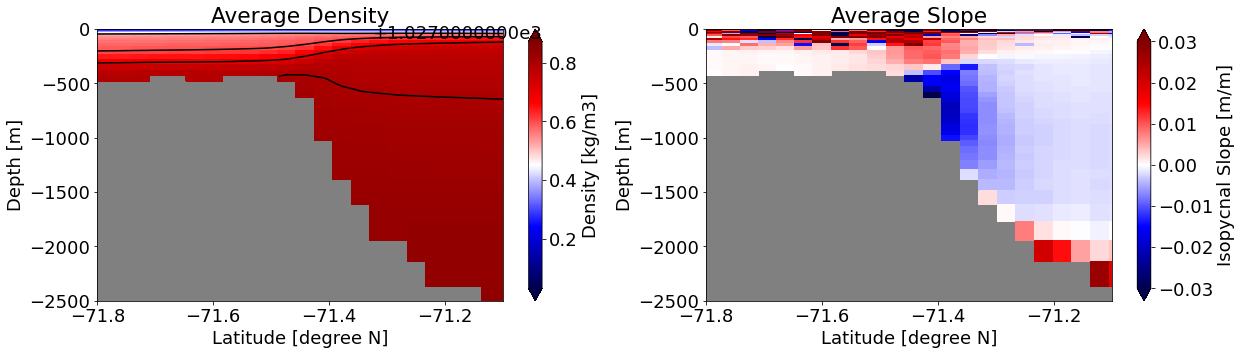

In [19]:
plt.figure(figsize=(20,5))
ax=plt.subplot(1,2,1)
ax.set_title('Average Density')
img=ax.pcolor(Qmean.YC, Qmean.Z, Qmean, cmap='seismic')
cn=ax.contour(Qmean.YC, Qmean.Z, Qmean, [1027.5, 1027.6, 1027.7, 1027.8], colors='k')
#ax.clabel(cn, [1027.5, 1027.6, 1027.7, 1027.8])
plt.colorbar(img, label='Density [kg/m3]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2500, 0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degree N]')
ax.set_facecolor('grey')

ax=plt.subplot(1,2,2)
ax.set_title('Average Slope')
img=ax.pcolor(dzdymean.YC, dzdymean.Z, dzdymean, cmap='seismic', vmin=-3e-2, vmax=3e-2)
#cn=ax.contour(dzdymean.YC, dzdymean.Z, Qmean, [1027.5, 1027.6, 1027.7, 1027.8], colors='k')
#ax.clabel(cn, [1027.5, 1027.6, 1027.7, 1027.8])
plt.colorbar(img, label='Isopycnal Slope [m/m]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2500, 0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degree N]')
ax.set_facecolor('grey')


In [40]:
lon=115
members='all'
dataU=loadMITgcmData(filename='UVEL_W'+str(lon), members=members, kind='slices')
melt=loadTimeSeriesData(filename='timeseries_final', members=members, kind='old')['dotson_to_cosgrove_massloss']
dataS=loadMITgcmData(filename='SALT_W'+str(lon), members=members, kind='slices')
dataT=loadMITgcmData(filename='THETA_W'+str(lon), members=members, kind='slices')
#Convert everything to density.
import sys
sys.path.append('/data/hpcdata/users/grejan/mitgcm/') #Make sure we can also import Kaitlins code.
from mitgcm_python_master.diagnostics import density
ref_depth=0
eosType='MDJWF'
dataS=dataS.where(dataS!=0, drop=True)
dataT=dataT.where(dataT!=0, drop=True)
salt=dataS['SALT'].to_numpy()
temp=dataT['THETA'].to_numpy()
q=density (eosType, salt, temp, press=ref_depth)
q=xr.DataArray(q, dims=('ens', 'time', "Z", "YC"), coords={'ens': dataS['SALT'].ens, 'time': dataS['SALT'].time, "YC": dataS['SALT'].YC, "Z": dataS['SALT'].Z})


Loading number:0
../02_data/slices/UVEL_W115_ens1.nc
Loading number:1
../02_data/slices/UVEL_W115_ens2.nc
Loading number:2
../02_data/slices/UVEL_W115_ens3.nc
Loading number:3
../02_data/slices/UVEL_W115_ens4.nc
Loading number:4
../02_data/slices/UVEL_W115_ens5.nc
Loading number:5
../02_data/slices/UVEL_W115_ens6.nc
Loading number:6
../02_data/slices/UVEL_W115_ens7.nc
Loading number:7
../02_data/slices/UVEL_W115_ens8.nc
Loading number:8
../02_data/slices/UVEL_W115_ens9.nc
Loading number:9
../02_data/slices/UVEL_W115_ens10.nc
Loading number:10
../02_data/slices/UVEL_W115_ens11.nc
Loading number:11
../02_data/slices/UVEL_W115_ens12.nc
Loading number:12
../02_data/slices/UVEL_W115_ens13.nc
Loading number:13
../02_data/slices/UVEL_W115_ens14.nc
Loading number:14
../02_data/slices/UVEL_W115_ens15.nc
Loading number:15
../02_data/slices/UVEL_W115_ens16.nc
Loading number:16
../02_data/slices/UVEL_W115_ens17.nc
Loading number:17
../02_data/slices/UVEL_W115_ens18.nc
Loading number:18
../02_data/

In [8]:
meltrm=detrend_and_average_MITgcmData(melt.to_dataset(name='melt'), var='melt', window=60)
dataS_dt=detrend_and_average_MITgcmData(dataS, var='SALT', window=1)
dataT_dt=detrend_and_average_MITgcmData(dataT, var='THETA', window=1)
dataQ_dt=detrend_and_average_MITgcmData(q.to_dataset(name='Q'), var='Q', window=1)

Qmean1=dataQ_dt.where(meltrm>meltrm.quantile(0.9)).mean(dim=['time', 'ens'])
Qmean2=dataQ_dt.where(meltrm<meltrm.quantile(0.1)).mean(dim=['time', 'ens'])

Smean1=dataS_dt.where(meltrm>meltrm.quantile(0.9)).mean(dim=['time', 'ens'])
Smean2=dataS_dt.where(meltrm<meltrm.quantile(0.1)).mean(dim=['time', 'ens'])

Tmean1=dataT_dt.where(meltrm>meltrm.quantile(0.9)).mean(dim=['time', 'ens'])
Tmean2=dataT_dt.where(meltrm<meltrm.quantile(0.1)).mean(dim=['time', 'ens'])


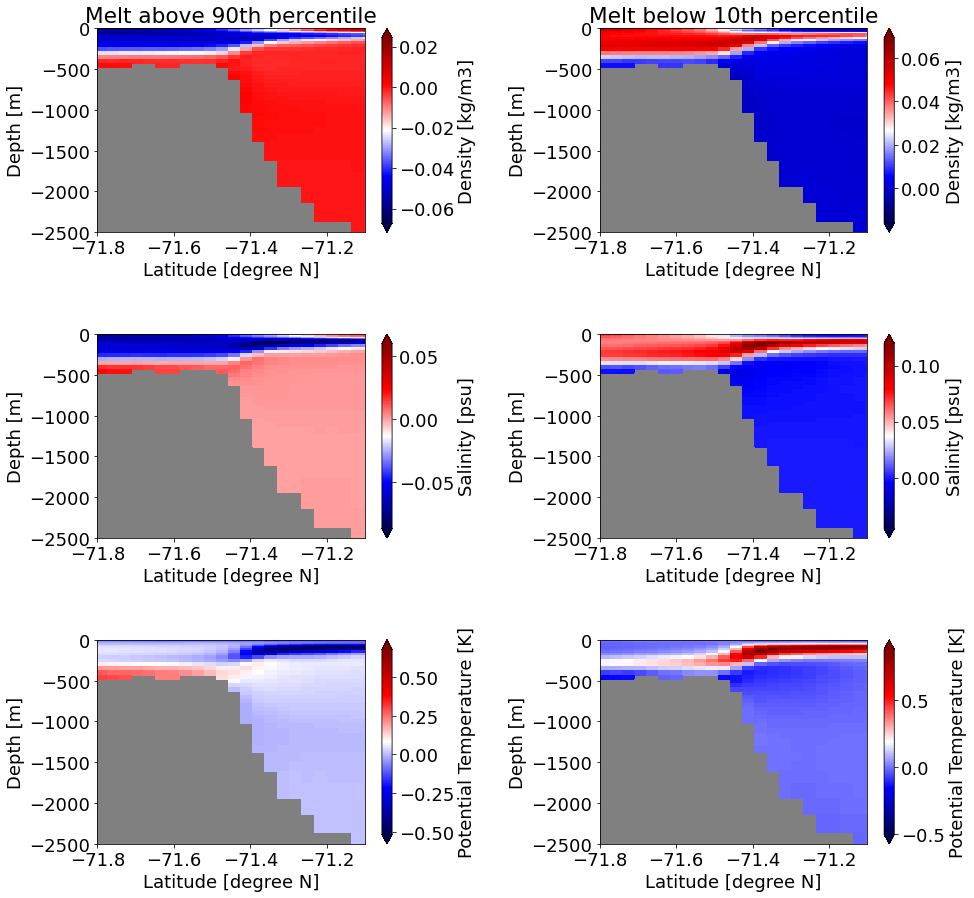

In [9]:
fig=plt.figure(figsize=(15,15))
ax=plt.subplot(3,2,1)
ax.set_title('Melt above 90th percentile')
img=ax.pcolor(Qmean1.YC, Qmean1.Z, Qmean1, cmap='seismic')
#cn=ax.contour(q.YC, q.Z, q.mean(dim='ens').sel(time=slice('1920', '1950')).mean(dim='time'), [1027.5, 1027.6, 1027.7, 1027.8], colors='k')
#ax.clabel(cn, [1027.5, 1027.6, 1027.7, 1027.8])
plt.colorbar(img, label='Density [kg/m3]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2500, 0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degree N]')
ax.set_facecolor('grey')

ax=plt.subplot(3,2,2)
ax.set_title('Melt below 10th percentile')
img=ax.pcolor(Qmean2.YC, Qmean2.Z, Qmean2, cmap='seismic')
#cn=ax.contour(q.YC, q.Z, q.mean(dim='ens').sel(time=slice('1920', '1950')).mean(dim='time'), [1027.5, 1027.6, 1027.7, 1027.8], colors='k')
#ax.clabel(cn, [1027.5, 1027.6, 1027.7, 1027.8])
plt.colorbar(img, label='Density [kg/m3]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2500, 0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degree N]')
ax.set_facecolor('grey')



ax=plt.subplot(3,2,3)
ax.set_title('')
img=ax.pcolor(Smean1.YC, Smean1.Z, Smean1, cmap='seismic')
plt.colorbar(img, label='Salinity [psu]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2500, 0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degree N]')
ax.set_facecolor('grey')


ax=plt.subplot(3,2,4)
ax.set_title('')
img=ax.pcolor(Smean2.YC, Smean2.Z, Smean2, cmap='seismic')
plt.colorbar(img, label='Salinity [psu]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2500, 0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degree N]')
ax.set_facecolor('grey')


ax=plt.subplot(3,2,5)
ax.set_title('')
img=ax.pcolor(Tmean1.YC, Tmean1.Z, Tmean1, cmap='seismic')
plt.colorbar(img, label='Potential Temperature [K]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2500, 0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degree N]')
ax.set_facecolor('grey')


ax=plt.subplot(3,2,6)
ax.set_title('')
img=ax.pcolor(Tmean2.YC, Tmean2.Z, Tmean2, cmap='seismic')
plt.colorbar(img, label='Potential Temperature [K]', extend='both')
if lon==115:
    ax.set_xlim([-71.8, -71.1])
elif lon==123:
    ax.set_xlim([-73, -72])
ax.set_ylim([-2500, 0])
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Latitude [degree N]')
ax.set_facecolor('grey')



fig.subplots_adjust(wspace=0.5, hspace=0.5)

In [41]:
meltrm=detrend_and_average_MITgcmData(melt.to_dataset(name='melt'), var='melt', window=1)
dataS_dt=detrend_and_average_MITgcmData(dataS, var='SALT', window=1)

meltrm['time']=meltrm.indexes['time'].to_datetimeindex()
dataS_dt['time']=dataS_dt.indexes['time'].to_datetimeindex()

/tmp/ipykernel_19208/2125511293.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  meltrm['time']=meltrm.indexes['time'].to_datetimeindex()
/tmp/ipykernel_19208/2125511293.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataS_dt['time']=dataS_dt.indexes['time'].to_datetimeindex()


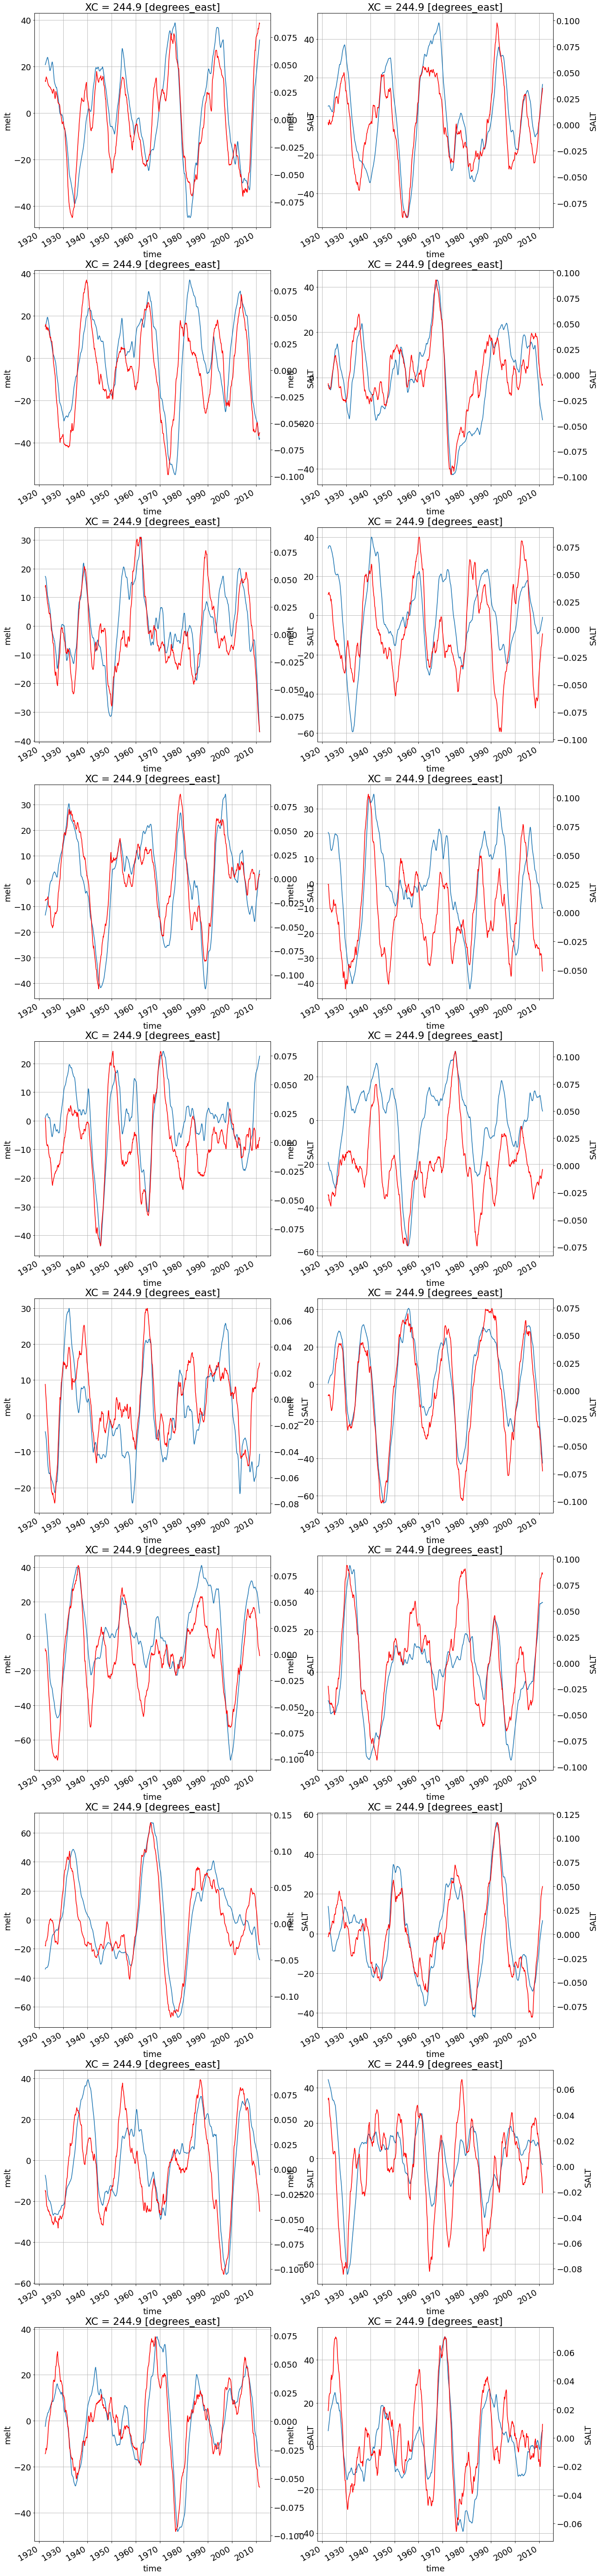

In [47]:
plt.figure(figsize=(20,5*len(meltrm.ens.values/2)))
for i in meltrm.ens.values:
    plt.subplot(10,2,i+1)
    meltrm.sel(ens=i).rolling(time=60, center=True).mean().plot()
    plt.grid(True)
    plt.twinx()
    (-1*dataS_dt.sel(ens=i, YC=slice(-71.6, -71.55), Z=slice(0,-200)).mean(dim=['YC','Z'])).rolling(time=60, center=True).mean().plot(c='r')
    #shelf=dataS_dt.sel(ens=i, YC=slice(-71.6, -71.55), Z=slice(0,-200)).mean(dim=['YC','Z'])
    #sea=dataS_dt.sel(ens=i, YC=slice(-71.3, -71.25), Z=slice(0,-200)).mean(dim=['YC','Z'])
    #(sea-shelf).rolling(time=60, center=True).mean().plot(c='r')
    #sea.rolling(time=60, center=True).mean().plot(c='r')
    #shelf.rolling(time=60, center=True).mean().plot(c='y')
    
    
    

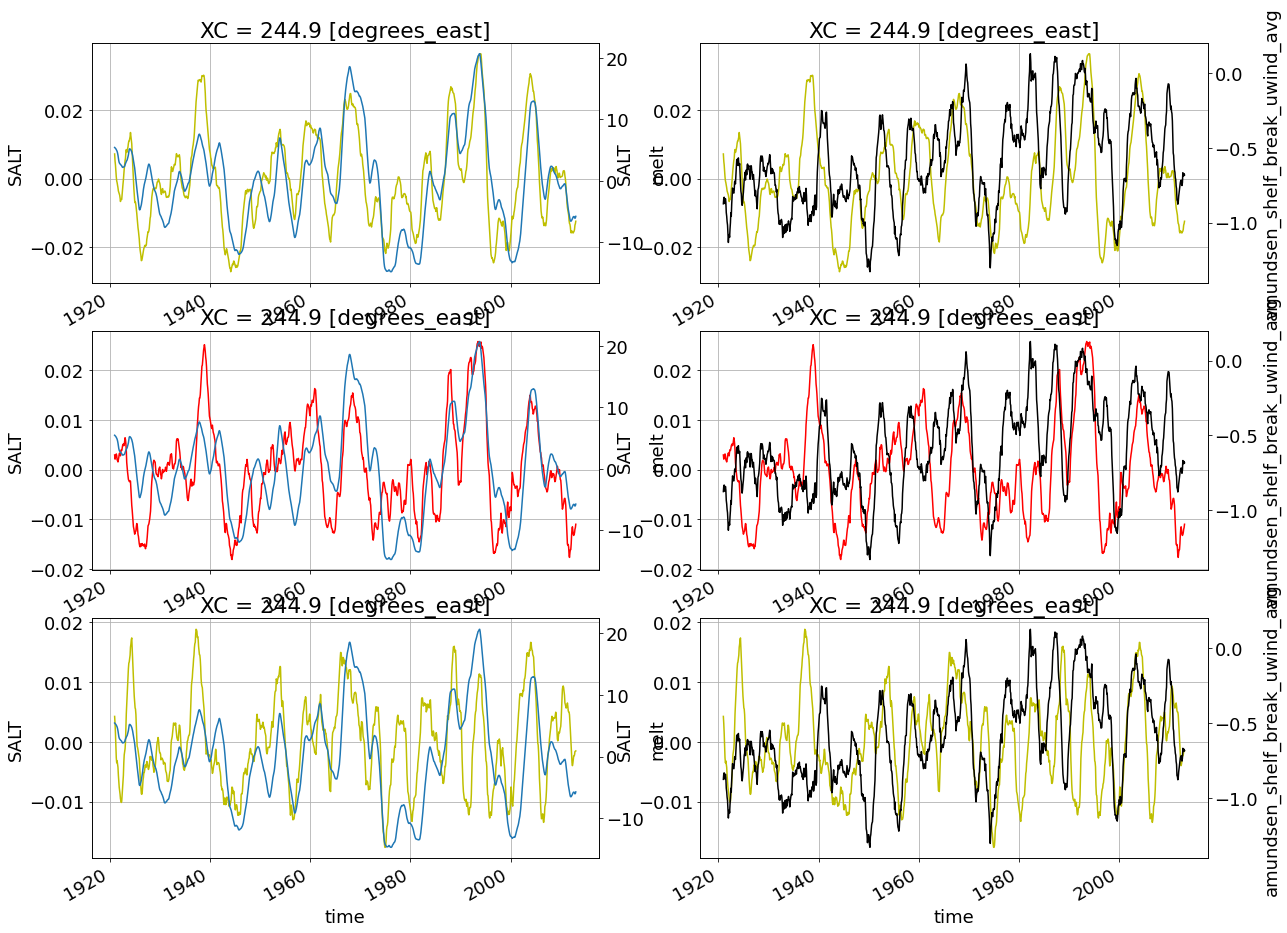

In [77]:
shelf=dataS_dt.sel(YC=slice(-71.6, -71.55), Z=slice(0,-200)).mean(dim=['YC','Z'])
sea=dataS_dt.sel(YC=slice(-71.3, -71.25), Z=slice(0,-200)).mean(dim=['YC','Z'])
#(sea-shelf).rolling(time=60, center=True).mean().plot(c='r')

plt.figure(figsize=(20,15))
plt.subplot(3,2,1)
(-1*shelf).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='y')
plt.grid(True)
plt.twinx()
meltrm.mean(dim='ens').rolling(time=24, center=True).mean().plot()


plt.subplot(3,2,2)
(-1*shelf).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='y')
plt.grid(True)
plt.twinx()
wind.sel(time=slice('1920', '2013')).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='k')



plt.subplot(3,2,3)
(-1*sea).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='r')
plt.grid(True)
plt.twinx()
meltrm.mean(dim='ens').rolling(time=24, center=True).mean().plot()

plt.subplot(3,2,4)
(-1*sea).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='r')
plt.grid(True)
plt.twinx()
wind.sel(time=slice('1920', '2013')).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='k')


plt.subplot(3,2,5)
(sea-shelf).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='y')
plt.grid(True)
plt.twinx()
meltrm.mean(dim='ens').rolling(time=24, center=True).mean().plot()


plt.subplot(3,2,6)
(sea-shelf).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='y')
plt.grid(True)
plt.twinx()
wind.sel(time=slice('1920', '2013')).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='k')


#sea.rolling(time=60, center=True).mean().plot(c='r')
#shelf.rolling(time=60, center=True).mean().plot(c='y')

In [61]:
#wind=loadTimeSeriesData(filename='timeseries_final', members=members, kind='old')['amundsen_shelf_break_uwind_avg']
wind['time']=wind.indexes['time'].to_datetimeindex()



/tmp/ipykernel_19208/2841166620.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  wind['time']=wind.indexes['time'].to_datetimeindex()


In [69]:
#shelffull=dataS.sel(YC=slice(-71.6, -71.55), Z=slice(0,-200)).mean(dim=['YC','Z'])
#seafull=dataS.sel(YC=slice(-71.3, -71.25), Z=slice(0,-200)).mean(dim=['YC','Z'])
shelffull['time']=shelffull.indexes['time'].to_datetimeindex()
seafull['time']=seafull.indexes['time'].to_datetimeindex()


/tmp/ipykernel_19208/958730924.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  shelffull['time']=shelffull.indexes['time'].to_datetimeindex()
/tmp/ipykernel_19208/958730924.py:4: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  seafull['time']=seafull.indexes['time'].to_datetimeindex()


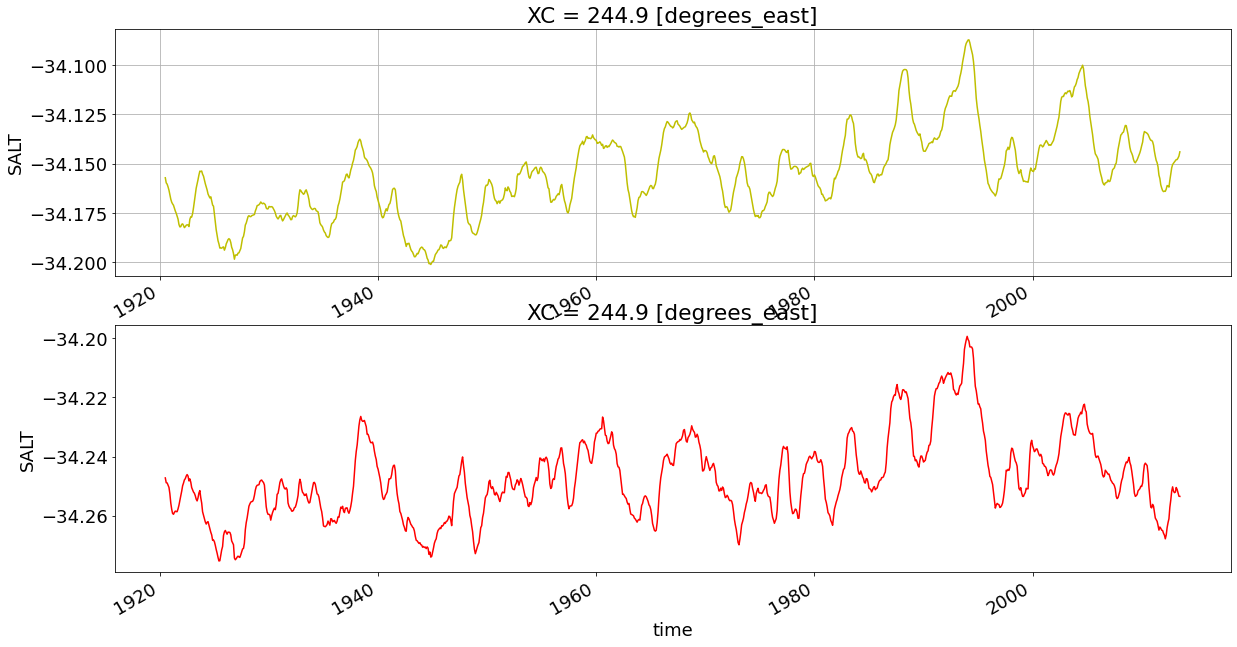

In [76]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
(-1*shelffull['SALT']).sel(time=slice('1920', '2013')).mean(dim='ens').rolling(time=12, center=True).mean().plot(c='y')
plt.grid(True)
plt.subplot(2,1,2)
(-1*seafull['SALT']).sel(time=slice('1920', '2013')).mean(dim='ens').rolling(time=12, center=True).mean().plot(c='r')

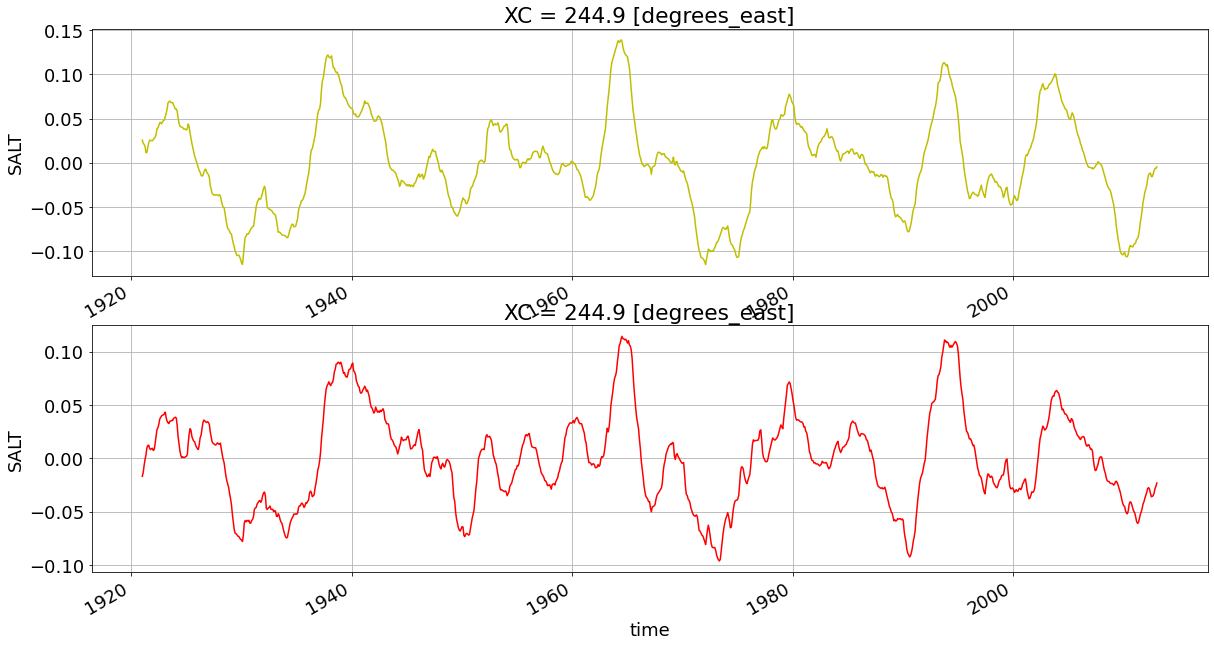

In [83]:
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
(-1*shelf).sel(ens=2).rolling(time=24, center=True).mean().plot(c='y')
plt.grid(True)
plt.subplot(2,1,2)
(-1*sea).sel(ens=2).rolling(time=24, center=True).mean().plot(c='r')
plt.grid(True)

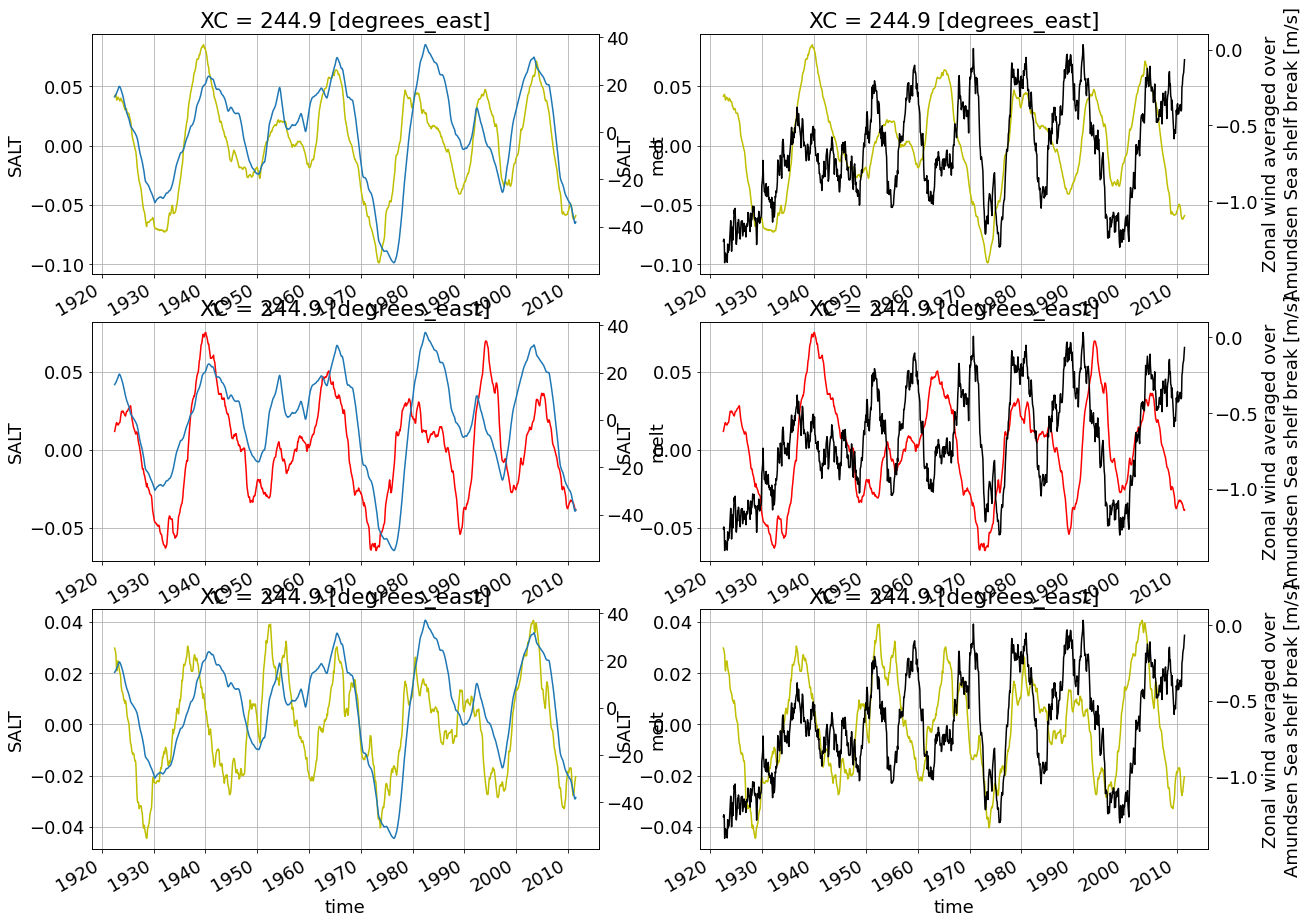

In [86]:
ens=2

shelf=dataS_dt.sel(YC=slice(-71.6, -71.55), Z=slice(0,-200)).mean(dim=['YC','Z'])
sea=dataS_dt.sel(YC=slice(-71.3, -71.25), Z=slice(0,-200)).mean(dim=['YC','Z'])
#(sea-shelf).rolling(time=60, center=True).mean().plot(c='r')

plt.figure(figsize=(20,15))
plt.subplot(3,2,1)
(-1*shelf).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='y')
plt.grid(True)
plt.twinx()
meltrm.sel(ens=ens).rolling(time=60, center=True).mean().plot()


plt.subplot(3,2,2)
(-1*shelf).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='y')
plt.grid(True)
plt.twinx()
wind.sel(time=slice('1920', '2013')).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='k')



plt.subplot(3,2,3)
(-1*sea).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='r')
plt.grid(True)
plt.twinx()
meltrm.sel(ens=ens).rolling(time=60, center=True).mean().plot()

plt.subplot(3,2,4)
(-1*sea).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='r')
plt.grid(True)
plt.twinx()
wind.sel(time=slice('1920', '2013')).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='k')


plt.subplot(3,2,5)
(sea-shelf).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='y')
plt.grid(True)
plt.twinx()
meltrm.sel(ens=ens).rolling(time=60, center=True).mean().plot()


plt.subplot(3,2,6)
(sea-shelf).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='y')
plt.grid(True)
plt.twinx()
wind.sel(time=slice('1920', '2013')).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='k')


#sea.rolling(time=60, center=True).mean().plot(c='r')
#shelf.rolling(time=60, center=True).mean().plot(c='y')

In [88]:
data_dt=detrend_and_average_MITgcmData(dataU, var='UVEL', window=1)
data_dt=data_dt.where(data_dt!=0, drop=True)

In [169]:
bottom=dataU['UVEL'].sel(YC=slice(-71.5, -71.4), Z=slice(-300, -1500)).mean(dim=['YC','Z'])
depth_averaged=dataU['UVEL'].sel(YC=slice(-71.5, -71.4)).mean(dim=['YC','Z'])
top=dataU['UVEL'].sel(YC=slice(-71.5, -71.4), Z=slice(0, -200)).mean(dim=['YC','Z'])


In [172]:
bottom['time']=bottom.indexes['time'].to_datetimeindex()
depth_averaged['time']=depth_averaged.indexes['time'].to_datetimeindex()
top['time']=top.indexes['time'].to_datetimeindex()

/tmp/ipykernel_19208/1261280950.py:1: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  bottom['time']=bottom.indexes['time'].to_datetimeindex()
/tmp/ipykernel_19208/1261280950.py:2: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  depth_averaged['time']=depth_averaged.indexes['time'].to_datetimeindex()
/tmp/ipykernel_19208/1261280950.py:3: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the lengt

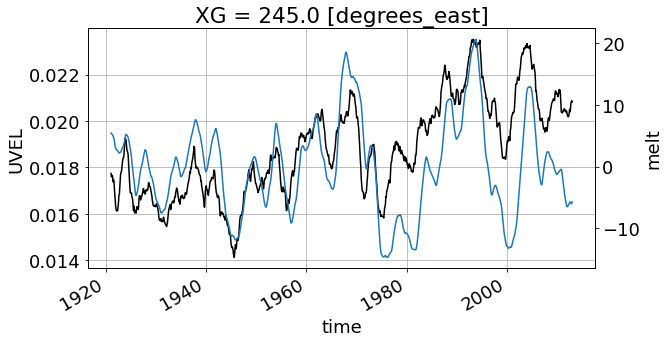

In [173]:
plt.figure(figsize=(20,15))
plt.subplot(3,2,1)
bottom.sel(time=slice('1920', '2013')).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='k')
plt.grid(True)
#depth_averaged.sel(time=slice('1920', '2013')).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='b')
#(bottom-depth_averaged).sel(time=slice('1920', '2013')).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='r')
#(bottom-top).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='y')
plt.twinx()
meltrm.mean(dim='ens').rolling(time=24, center=True).mean().plot()


# plt.subplot(3,2,2)
# (-1*shelf).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='y')
# plt.grid(True)
# plt.twinx()
# wind.sel(time=slice('1920', '2013')).mean(dim='ens').rolling(time=24, center=True).mean().plot(c='k')



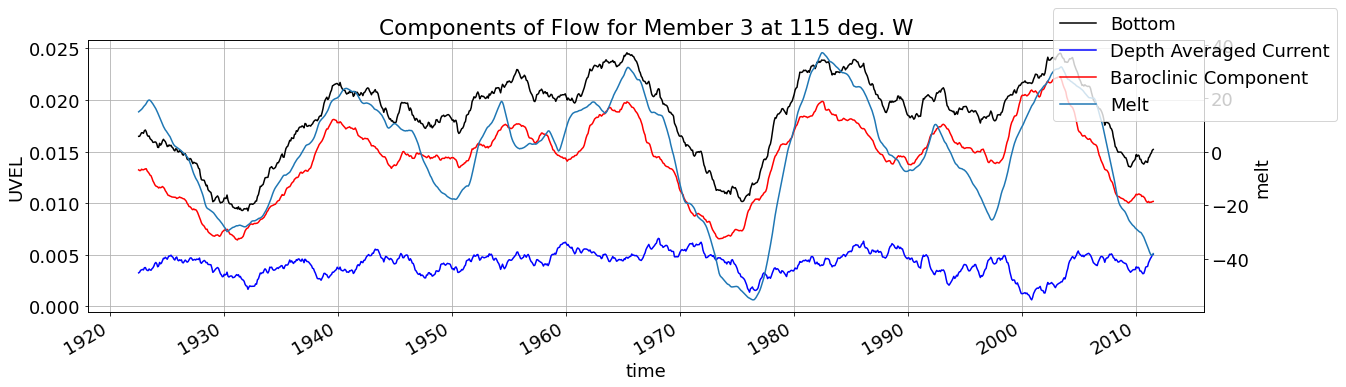

In [179]:
ens=2
fig=plt.figure(figsize=(20,5))
plt.subplot(1,1,1)
bottom.sel(time=slice('1920', '2013')).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='k', label='Bottom')
plt.grid(True)
(depth_averaged).sel(time=slice('1920', '2013')).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='b', label='Depth Averaged Current')
(bottom-depth_averaged).sel(time=slice('1920', '2013')).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='r', label='Baroclinic Component')
#(bottom-top).sel(time=slice('1920', '2013')).sel(ens=ens).rolling(time=60, center=True).mean().plot(c='y')
plt.title('Components of Flow for Member 3 at 115 deg. W')
plt.twinx()
meltrm.sel(ens=ens).rolling(time=60, center=True).mean().plot(label='Melt')
fig.legend()




In [22]:
UVEL=xr.open_dataset('../data/depth_averaged_UVEL_ens1.nc')
VVEL=xr.open_dataset('../data/depth_averaged_VVEL_ens1.nc')
VVEL=VVEL.rename({'VVEL':'UVEL'})

if 'XG' in UVEL.dims:
    UVEL=UVEL.rename({'XG':'XC'})
if 'YG' in UVEL.dims:
    UVEL=UVEL.rename({'YG':'YC'})
if 'XG' in VVEL.dims:
    VVEL=VVEL.rename({'XG':'XC'})
if 'YG' in VVEL.dims:
    VVEL=VVEL.rename({'YG':'YC'})
    
#Read something with the correct locations.
data=loadMITgcmData(filename='EXFuwind', members=[0,1], kind='maps')
    
UVEL=UVEL.interp(XC=data.XC, YC=data.YC)
VVEL=VVEL.interp(XC=data.XC, YC=data.YC)

barotropic=np.sqrt(UVEL**2+VVEL**2)
barotropic

Loading number:0
../02_data/maps/EXFuwind_ens1.nc


/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing metho

<xarray.Dataset>
Dimensions:  (time: 1488, YC: 384, XC: 600)
Coordinates:
  * time     (time) object 1890-02-01 00:00:00 ... 2014-01-01 00:00:00
  * XC       (XC) float32 220.1 220.1 220.2 220.4 ... 279.6 279.8 279.9 280.0
  * YC       (YC) float32 -75.64 -75.61 -75.59 -75.56 ... -62.48 -62.44 -62.39
Data variables:
    UVEL     (time, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan nan

In [20]:
UVEL=xr.open_dataset('../data/bottom100m_averaged_UVEL_ens1.nc')
VVEL=xr.open_dataset('../data/bottom100m_averaged_VVEL_ens1.nc')
VVEL=VVEL.rename({'VVEL':'UVEL'})

if 'XG' in UVEL.dims:
    UVEL=UVEL.rename({'XG':'XC'})
if 'YG' in UVEL.dims:
    UVEL=UVEL.rename({'YG':'YC'})
if 'XG' in VVEL.dims:
    VVEL=VVEL.rename({'XG':'XC'})
if 'YG' in VVEL.dims:
    VVEL=VVEL.rename({'YG':'YC'})
    
#Read something with the correct locations.
data=loadMITgcmData(filename='EXFuwind', members=[0,1], kind='maps')
    
UVEL=UVEL.interp(XC=data.XC, YC=data.YC)
VVEL=VVEL.interp(XC=data.XC, YC=data.YC)

bottom=np.sqrt(UVEL**2+VVEL**2)
bottom

Loading number:0
../02_data/maps/EXFuwind_ens1.nc


/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imax = index.get_loc(maxval, method="nearest")
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:562: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  imin = index.get_loc(minval, method="nearest")
/users/grejan/conda-envs/amundsen/lib/python3.9/site-packages/xarray/core/missing.py:563: FutureWarning: Passing metho

<xarray.Dataset>
Dimensions:  (time: 1488, YC: 384, XC: 600)
Coordinates:
  * time     (time) object 1890-02-01 00:00:00 ... 2014-01-01 00:00:00
  * XC       (XC) float32 220.1 220.1 220.2 220.4 ... 279.6 279.8 279.9 280.0
  * YC       (YC) float32 -75.64 -75.61 -75.59 -75.56 ... -62.48 -62.44 -62.39
Data variables:
    UVEL     (time, YC, XC) float32 nan nan nan nan nan ... nan nan nan nan nan

In [23]:
baroclinic=bottom-barotropic

In [24]:
barotropic_mean=barotropic.sel(time=slice('1920', '2013')).mean(dim='time')
baroclinic_mean=baroclinic.sel(time=slice('1920', '2013')).mean(dim='time')

# barotropic_std=barotropic.sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().std(dim='time')
# baroclinic_std=baroclinic.sel(time=slice('1920', '2013')).rolling(time=60, center=True).mean().std(dim='time')
barotropic_std=barotropic.sel(time=slice('1920', '2013')).rolling(time=1, center=True).mean().std(dim='time')
baroclinic_std=baroclinic.sel(time=slice('1920', '2013')).rolling(time=1, center=True).mean().std(dim='time')

(0.0, 200.0)

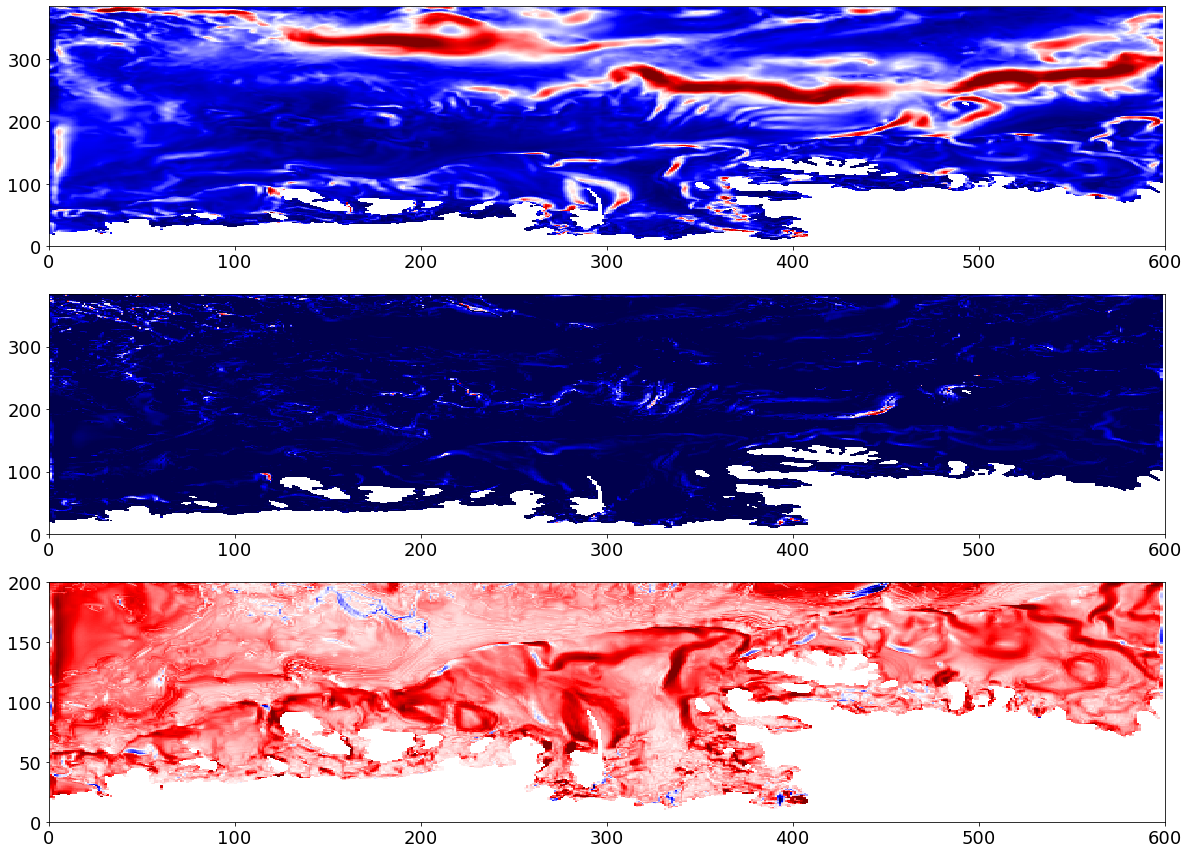

In [184]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
plt.pcolor(barotropic_mean['UVEL'], vmin=0, vmax=0.1, cmap='seismic')

plt.subplot(3,1,2)
plt.pcolor(baroclinic_mean['UVEL'], vmin=0, vmax=0.1, cmap='seismic')

plt.subplot(3,1,3)
plt.pcolor(abs(barotropic_mean['UVEL'])-abs(baroclinic_mean['UVEL']), vmin=-0.05, vmax=0.05, cmap='seismic')
plt.ylim([0,200])

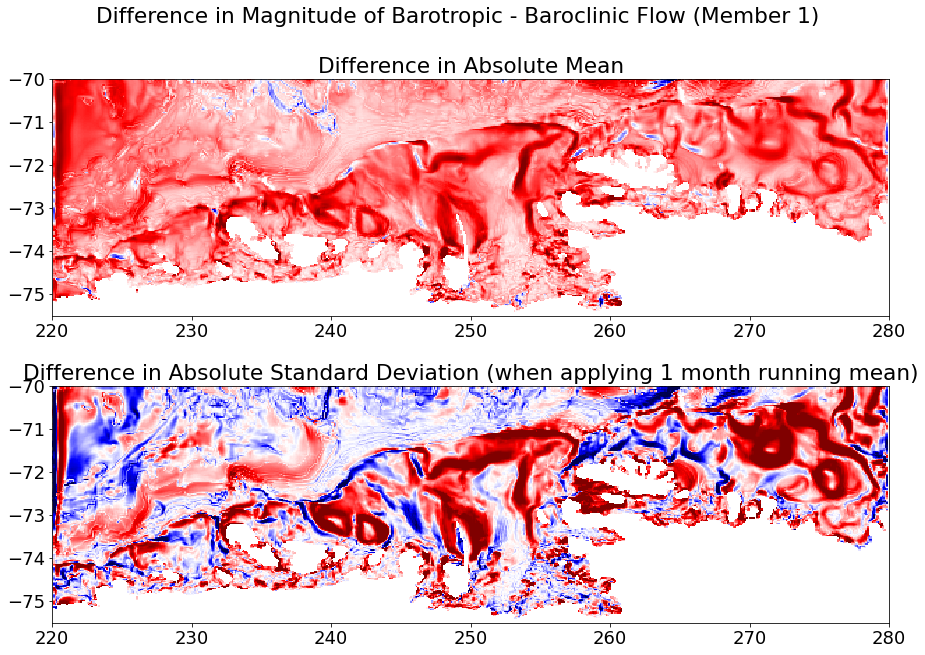

In [25]:
plt.figure(figsize=(15,10))
plt.suptitle('Difference in Magnitude of Barotropic - Baroclinic Flow (Member 1)')
plt.subplot(2,1,1)
plt.title('Difference in Absolute Mean')
plt.pcolor(barotropic.XC, barotropic.YC, abs(barotropic_mean['UVEL'])-abs(baroclinic_mean['UVEL']), vmin=-0.05, vmax=0.05, cmap='seismic')
plt.ylim([-75.5,-70])

plt.subplot(2,1,2)
#plt.title('Difference in Absolute Standard Deviation (when applying 60 month running mean)')
plt.title('Difference in Absolute Standard Deviation (when applying 1 month running mean)')

plt.pcolor(barotropic.XC, barotropic.YC, abs(barotropic_std['UVEL'])-abs(baroclinic_std['UVEL']), vmin=-0.01, vmax=0.01, cmap='seismic')
plt.ylim([-75.5,-70])
plt.subplots_adjust(hspace=0.3)

In [171]:
bottom

<xarray.DataArray 'UVEL' (ens: 20, time: 1488)>
array([[-0.00353647,  0.00584401,  0.02040585, ...,  0.02838976,
         0.02255423,  0.027607  ],
       [-0.00029859,  0.01091497,  0.02420079, ...,  0.01651924,
         0.0254993 ,  0.01840889],
       [-0.0010991 ,  0.00767088,  0.02313835, ...,  0.0210452 ,
         0.01725239,  0.00772893],
       ...,
       [-0.00131008,  0.00998431,  0.02271033, ...,  0.00321163,
         0.02134803,  0.02904526],
       [-0.00469073,  0.01179262,  0.01734163, ...,  0.01854272,
         0.01919555,  0.02094423],
       [-0.00139452,  0.01313369,  0.02118738, ...,  0.01060673,
         0.02187664,  0.03969223]], dtype=float32)
Coordinates:
    iter     (time) int64 4464 8496 12960 17280 ... 6508656 6512976 6517440
  * time     (time) object 1890-02-01 00:00:00 ... 2014-01-01 00:00:00
    XG       float32 245.0
Dimensions without coordinates: ens

Surface Flux Budget

In [3]:
%%capture
forcing=loadTimeSeriesData(filename='timeseries_forcing', members='all', kind='old')
forcing['time']=forcing.indexes['time'].to_datetimeindex()
melt=loadTimeSeriesData(filename='timeseries_final', members='all', kind='old')
melt['time']=melt.indexes['time'].to_datetimeindex()
# surface=False
# salt=loadTimeSeriesData(filename='timeseries_salt', members='all', kind='timeseries')
# salt['time']=salt.indexes['time'].to_datetimeindex()
surface=True
salt=loadTimeSeriesData(filename='timeseries_salt_0to200', members='all', kind='timeseries')
salt['time']=salt.indexes['time'].to_datetimeindex()


salt=salt.rename({'amundsen_shelf_salt_btw_0_200m':'amundsen_shelf_salt_below_0m'})

In [4]:
factor= 10**9/(917*365*24*3600) #Gt/yr to m^3/s

shelf=melt['all_massloss'].sel(time=slice('1920', '2013'))*factor
seaice=(forcing['amundsen_shelf_seaice_freeze']+forcing['amundsen_shelf_seaice_melt']).sel(time=slice('1920', '2013'))
prec=forcing['amundsen_shelf_pmepr'].sel(time=slice('1920', '2013'))

shelf_dt=detrend_and_average_MITgcmData(shelf.to_dataset(name='shelf'), var='shelf', window=60)
seaice_dt=detrend_and_average_MITgcmData(seaice.to_dataset(name='seaice'), var='seaice', window=60)
prec_dt=detrend_and_average_MITgcmData(prec.to_dataset(name='prec'), var='prec', window=60)

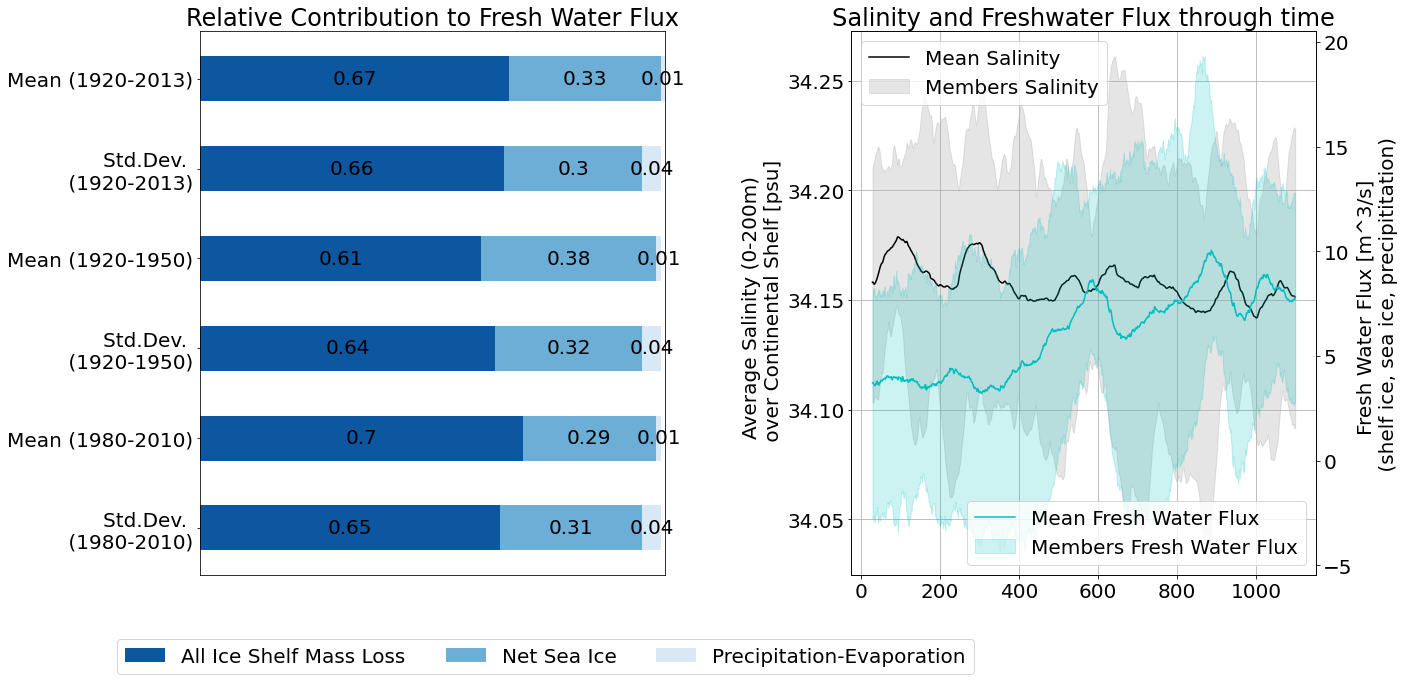

In [47]:
import numpy as np
import matplotlib.pyplot as plt


category_names = ['All Ice Shelf Mass Loss', 'Net Sea Ice',
                  'Precipitation-Evaporation']


shelfmean=abs(shelf.mean(dim=['time', 'ens']))
seaicemean=abs(seaice.mean(dim=['time', 'ens']))
precmean=abs(prec.mean(dim=['time', 'ens']))
fullmean=shelfmean+seaicemean+precmean
shelfmean/=fullmean
seaicemean/=fullmean
precmean/=fullmean


shelfstd=abs(shelf_dt.std(dim='time').mean(dim=['ens']))
seaicestd=abs(seaice_dt.std(dim='time').mean(dim=['ens']))
precstd=abs(prec_dt.std(dim='time').mean(dim=['ens']))
fullstd=shelfstd+seaicestd+precstd
shelfstd/=fullstd
seaicestd/=fullstd
precstd/=fullstd


shelfmean_1950=abs(shelf.sel(time=slice('1920', '1950')).mean(dim=['time', 'ens']))
seaicemean_1950=abs(seaice.sel(time=slice('1920', '1950')).mean(dim=['time', 'ens']))
precmean_1950=abs(prec.sel(time=slice('1920', '1950')).mean(dim=['time', 'ens']))
fullmean_1950=shelfmean_1950+seaicemean_1950+precmean_1950
shelfmean_1950/=fullmean_1950
seaicemean_1950/=fullmean_1950
precmean_1950/=fullmean_1950


shelfstd_1950=abs(shelf_dt.sel(time=slice('1920', '1950')).std(dim='time').mean(dim=['ens']))
seaicestd_1950=abs(seaice_dt.sel(time=slice('1920', '1950')).std(dim='time').mean(dim=['ens']))
precstd_1950=abs(prec_dt.sel(time=slice('1920', '1950')).std(dim='time').mean(dim=['ens']))
fullstd_1950=shelfstd_1950+seaicestd_1950+precstd_1950
shelfstd_1950/=fullstd_1950
seaicestd_1950/=fullstd_1950
precstd_1950/=fullstd_1950


shelfmean_2010=abs(shelf.sel(time=slice('1980', '2010')).mean(dim=['time', 'ens']))
seaicemean_2010=abs(seaice.sel(time=slice('1980', '2010')).mean(dim=['time', 'ens']))
precmean_2010=abs(prec.sel(time=slice('1980', '2010')).mean(dim=['time', 'ens']))
fullmean_2010=shelfmean_2010+seaicemean_2010+precmean_2010
shelfmean_2010/=fullmean_2010
seaicemean_2010/=fullmean_2010
precmean_2010/=fullmean_2010


shelfstd_2010=abs(shelf_dt.sel(time=slice('1980', '2010')).std(dim='time').mean(dim=['ens']))
seaicestd_2010=abs(seaice_dt.sel(time=slice('1980', '2010')).std(dim='time').mean(dim=['ens']))
precstd_2010=abs(prec_dt.sel(time=slice('1980', '2010')).std(dim='time').mean(dim=['ens']))
fullstd_2010=shelfstd_2010+seaicestd_2010+precstd_2010
shelfstd_2010/=fullstd_2010
seaicestd_2010/=fullstd_2010
precstd_2010/=fullstd_2010


results = {
    'Mean (1920-2013)': [np.round(shelfmean,2), np.round(seaicemean,2),  np.round(precmean,2)],
    'Std.Dev. \n (1920-2013)': 
    [np.round(shelfstd,2), np.round(seaicestd,2),  np.round(precstd,2)],
    
    'Mean (1920-1950)': [np.round(shelfmean_1950,2), np.round(seaicemean_1950,2),  np.round(precmean_1950,2)],
    'Std.Dev. \n (1920-1950)': 
    [np.round(shelfstd_1950,2), np.round(seaicestd_1950,2),  np.round(precstd_1950,2)],
    
    'Mean (1980-2010)': [np.round(shelfmean_2010,2), np.round(seaicemean_2010,2),  np.round(precmean_2010,2)],
    'Std.Dev. \n (1980-2010)': 
    [np.round(shelfstd_2010,2), np.round(seaicestd_2010,2),  np.round(precstd_2010,2)],
}

def survey(results, category_names, ax):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*.
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.colormaps['Blues_r'](
        np.linspace(0.15, 0.85, data.shape[1]))

    #fig, ax = plt.subplots(figsize=(9.2, 5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        rects = ax.barh(labels, widths, left=starts, height=0.5,
                        label=colname, color=color)

        r, g, b, _ = color
        text_color = 'black' #if r * g * b < 0.5 else 'darkgrey'
        ax.bar_label(rects, label_type='center', color=text_color)
    ax.legend(ncol=len(category_names), bbox_to_anchor=(-0.2, -0.2),
              loc='lower left')

    return ax

plt.rcParams.update({'font.size': 20})

fig=plt.figure(figsize=(20,10))
ax=plt.subplot(1,2,1)
ax=survey(results, category_names, ax)
ax.set_title('Relative Contribution to Fresh Water Flux')

handpicked=[2,5,9,8,16]

# ax1=plt.subplot(2,2,3)
# for i in range(20):
#     if i==0:
#         salt['amundsen_shelf_salt_below_0m'].sel(ens=i,
#         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='grey', 
#                                                                               linewidth=0.2,  label='Member')
#     else:
#         salt['amundsen_shelf_salt_below_0m'].sel(ens=i,
#             time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='grey', linewidth=0.2)
# # for i in handpicked:
# #     salt['amundsen_shelf_salt_below_0m'].sel(ens=i,
# #         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='blue', linewidth=0.2)
# # salt['amundsen_shelf_salt_below_0m'].sel(ens=handpicked).mean(dim='ens').sel(
# #         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='r', linewidth=1.2)
# salt['amundsen_shelf_salt_below_0m'].mean(dim='ens').sel(
#         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='k', linewidth=1.2, label='Mean')
# if surface:
#     plt.ylabel('Average Salinity (0-200m) \n over Continental Shelf [psu]')
# else:
#     plt.ylabel('Average Salinity over \n Continental Shelf [psu]')
# plt.grid()
# plt.legend()

# cumul=shelf+seaice+prec
# ax2=plt.subplot(2,2,2)
# for i in range(20):
#     if i==0:
#         cumul.sel(ens=i,
#             time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='grey', label='Member', linewidth=0.2)
#     else:
#         cumul.sel(ens=i,
#         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='grey', linewidth=0.2)

# # for i in handpicked:
# #     cumul.sel(ens=i,
# #         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='blue', linewidth=0.2)
# # cumul.sel(ens=handpicked).mean(dim='ens').sel(
# #         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='r', linewidth=1.2)
# cumul.mean(dim='ens').sel(
#         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='c', linewidth=1.2, label='Mean')
# plt.ylabel('Fresh Water Flux [m^3/s] \n (shelf ice, sea ice, precipititation) ')
# plt.grid()
# plt.legend()

ax=plt.subplot(1,2,2)
mean=salt['amundsen_shelf_salt_below_0m'].mean(dim='ens').sel(
        time=slice('1920', '2013')).rolling(time=60, center=True).mean()
maximum=salt['amundsen_shelf_salt_below_0m'].sel(
        time=slice('1920', '2013')).rolling(time=60, center=True).mean().max(dim='ens')
minimum=salt['amundsen_shelf_salt_below_0m'].sel(
        time=slice('1920', '2013')).rolling(time=60, center=True).mean().min(dim='ens')
                                                                              
# melt['amundsen_shelf_sss_avg'].mean(dim='ens').sel(
#         time=slice('1920', '2013')).rolling(time=60, center=True).mean().plot(c='k', linewidth=1.2)

plt.plot(range(len(mean.time)), mean, c='k', label='Mean Salinity', linewidth=1.5)

plt.fill_between(x=range(len(mean.time)), y1=minimum, y2=maximum, color='grey', alpha=0.2, label='Members Salinity')

ax.set_ylim(ax1.get_ylim())
if surface:
    plt.ylabel('Average Salinity (0-200m) \n over Continental Shelf [psu]')
else:
    plt.ylabel('Average Salinity over \n Continental Shelf [psu]')
plt.grid()
plt.legend(loc='upper left')
plt.twinx()
mean=cumul.mean(dim='ens').sel(
        time=slice('1920', '2013')).rolling(time=60, center=True).mean()

maximum=cumul.sel(
        time=slice('1920', '2013')).rolling(time=60, center=True).mean().max(dim='ens')

minimum=cumul.sel(
        time=slice('1920', '2013')).rolling(time=60, center=True).mean().min(dim='ens')

plt.plot(range(len(mean.time)), mean, c='c', label='Mean Fresh Water Flux', linewidth=1.5)

plt.fill_between(x=range(len(mean.time)), y1=minimum, y2=maximum, color='c', alpha=0.2, label='Members Fresh Water Flux')

plt.ylim(ax2.get_ylim())
plt.ylabel('Fresh Water Flux [m^3/s] \n (shelf ice, sea ice, precipititation) ')
plt.legend(loc='lower right')
ax.set_title('Salinity and Freshwater Flux through time')
fig.subplots_adjust(hspace=0.4, wspace=0.4)
#plt.show()

from datetime import date
today = date.today()
today=today.strftime("%Y%m%d")
plt.savefig('/data/hpcdata/users/grejan/mitgcm/03_output/other/'+today+'_freshwater_budget.png')

In [23]:
type(maximum.values[0])

numpy.float64

In [33]:
minimum.time.to_numpy().dt.to_datetime()

AttributeError: 'numpy.ndarray' object has no attribute 'dt'

In [2]:
from functions.correlation_maps import correlationMap_1D_v3


In [ ]:
window=60
data=xr.open_dataset('/data/hpcdata/users/grejan/mitgcm/02_data/maps/baroclinic_VEL_ensmean.nc')
data=data.expand_dims('ens')
ind=loadTimeSeriesData(filename='timeseries_final', members='all', kind='old')['dotson_to_cosgrove_massloss']
ind=ind.mean(dim='ens').expand_dims('ens')

In [ ]:
correlationMap_1D_v3(members=[20,21],
                  data=data, datafn='baroclinic_VEL', datavar='UVEL', datakind='maps',
                  ind=ind, indfn='timeseries_final', indvar='dotson_to_cosgrove_massloss', lags=range(-24, 24),
                  mask='land', years=['1920', '2013'],
                  detrend=True, deseasonalize=True, window=window, title='1D Correlation Map Ensemble Mean Baroclinic Flow and Dotson to Cosgrove Melt', ymax=-70, 
                  save=False, savefn='test',
                  draw_box=False, box_x=[360-115, 360-102],box_y=[-71.8, -70.2],
                  inverse=False, save_results=True, give_back=False, cumsum_map=False, cumsum_ind=False)

In [ ]:
data=xr.open_dataset('/data/hpcdata/users/grejan/mitgcm/02_data/maps/depth_averaged_VEL_ensmean.nc')
data=data.expand_dims('ens')

In [ ]:
correlationMap_1D_v3(members=[20,21],
                  data=data, datafn='depth_averaged_VEL', datavar='UVEL', datakind='maps',
                  ind=ind, indfn='timeseries_final', indvar='dotson_to_cosgrove_massloss', lags=range(-24, 24),
                  mask='land', years=['1920', '2013'],
                  detrend=True, deseasonalize=True, window=window, title='1D Correlation Map Ensemble Mean Barotropic Flow and Dotson to Cosgrove Melt', ymax=-70, 
                save=False, savefn='test',
                  draw_box=False, box_x=[360-115, 360-102],box_y=[-71.8, -70.2],
                  inverse=False, save_results=True, give_back=False, cumsum_map=False, cumsum_ind=False)